In [1]:
%matplotlib inline


### Supervised Learning : Recurrent Neural Networks 

Welcome to the "Supervised Learning : Recurrent Neural Networks" practical session.  

Programming Language : Python 
Editor : Jupyter Notebook. 

Pandas : Data loading, processing, transformation and manipulation.
Scikit-learn : Example data source, ML and statistical analysis


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt


#### Load relevant data and partition the data for train and test
Here we will use a covid 19 confirmed new infection data set.
After loading the data we will partition the data into train and test. 
In this example we will 95% data for training and remaining 5% will be left for testing. 

In [7]:
## We Load the complete data for new infection  ##


df = pd.read_csv('Covid_19_train.csv', sep = ",", header=None )
df.columns = ["date", "new_infections"]
df

,date,new_infections
0,2020-01-22,0.0
1,2020-01-23,0.0
2,2020-01-24,0.0
3,2020-01-25,0.0
4,2020-01-26,0.0
...,...,...
72,2020-04-03,119827.0
73,2020-04-04,124632.0
74,2020-04-05,128948.0
75,2020-04-06,132547.0


In [8]:

## Preprocess data
data = df['new_infections'].values
data = data.reshape(-1, 1)
print(data)

[[0.00000e+00]
 [0.00000e+00]
 [0.00000e+00]
 [0.00000e+00]
 [0.00000e+00]
 [0.00000e+00]
 [0.00000e+00]
 [0.00000e+00]
 [0.00000e+00]
 [2.00000e+00]
 [2.00000e+00]
 [2.00000e+00]
 [2.00000e+00]
 [2.00000e+00]
 [2.00000e+00]
 [2.00000e+00]
 [3.00000e+00]
 [3.00000e+00]
 [3.00000e+00]
 [3.00000e+00]
 [3.00000e+00]
 [3.00000e+00]
 [3.00000e+00]
 [3.00000e+00]
 [3.00000e+00]
 [3.00000e+00]
 [3.00000e+00]
 [3.00000e+00]
 [3.00000e+00]
 [3.00000e+00]
 [2.00000e+01]
 [6.20000e+01]
 [1.55000e+02]
 [2.29000e+02]
 [3.22000e+02]
 [4.53000e+02]
 [6.55000e+02]
 [8.88000e+02]
 [1.12800e+03]
 [1.69400e+03]
 [2.03600e+03]
 [2.50200e+03]
 [3.08900e+03]
 [3.85800e+03]
 [4.63600e+03]
 [5.88300e+03]
 [7.37500e+03]
 [9.17200e+03]
 [1.01490e+04]
 [1.24620e+04]
 [1.24620e+04]
 [1.76600e+04]
 [2.11570e+04]
 [2.47470e+04]
 [2.79800e+04]
 [3.15060e+04]
 [3.57130e+04]
 [4.10350e+04]
 [4.70210e+04]
 [5.35780e+04]
 [5.91380e+04]
 [6.39270e+04]
 [6.91760e+04]
 [7.43860e+04]
 [8.05890e+04]
 [8.64980e+04]
 [9.24720e

In [9]:

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Splitting full data set into train and test sets
training_data_len = int(np.ceil( len(scaled_data) * .95 ))

train_data = scaled_data[0:int(training_data_len), :]
test_data = scaled_data[int(training_data_len)-7: , :]

### Splitting Data into Sequences

This block defines a function create_sequences() to split the scaled data into sequences of 7 days each (a week), where the target for each sequence is the number of new cases on the 8th day.

In [16]:
# Create sequences
def create_sequences(data):
    X, y = [], []
    for i in range(7, len(data)):
        X.append(data[i-7:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

# Reshape the input into the shape required by LSTM layers
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(y_train.shape)

(67,)


### Creating the LSTM ( An advanced variation of RNN ) Model:

In this section, we define our LSTM model using the Sequential model API from Keras.

- Sequential() initiates a linear stack of layers that you can add to one at a time with the add() function.

- The first layer is an LSTM layer with 50 units/neurons, return_sequences=True means it returns the full sequence as output. This is necessary when stacking LSTM layers so that the following LSTM layer has the same sequence input. The input_shape is defined according to our training data (X_train.shape[1], 1).

- The second LSTM layer also has 50 units but return_sequences=False this time. This means the LSTM will only return the output of the last time step, which is the default behavior and is suitable for this setup where we only care about the final prediction.

- Then we add two Dense (fully connected) layers. The first one with 25 neurons and the second one with 1 neuron. The final dense layer has only one unit, which corresponds to our goal of predicting a single value.


- Here we compile the model with the Adam optimizer and the Mean Squared Error (MSE) loss function. Adam is an efficient gradient descent optimization algorithm that's widely used in deep learning models. MSE is a popular loss function for regression problems, which measures the average squared differences between the predicted and actual values.

- Finally, we fit (train) the model for a fixed number of epochs (iterations on a dataset). It uses our training data and labels (X_train and y_train), with the model trained for 50 epochs and a batch size of 32. The batch size is the number of samples that will be propagated through the network at once.

In [17]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

2023-06-21 14:23:43.953847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 14:23:43.955791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 14:23:43.956636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-06-21 14:23:44.620555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 14:23:44.623012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 14:23:44.624617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 3s 15ms/step - loss: 0.0868
Epoch 2/50
3/3 [==============================] - 0s 16ms/step - loss: 0.0509
Epoch 3/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0296
Epoch 4/50
3/3 [==============================] - 0s 17ms/step - loss: 0.0238
Epoch 5/50
3/3 [==============================] - 0s 17ms/step - loss: 0.0207
Epoch 6/50
3/3 [==============================] - 0s 16ms/step - loss: 0.0108
Epoch 7/50
3/3 [==============================] - 0s 18ms/step - loss: 0.0036
Epoch 8/50
3/3 [==============================] - 0s 19ms/step - loss: 0.0025
Epoch 9/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0037
Epoch 10/50
3/3 [==============================] - 0s 26ms/step - loss: 0.0042
Epoch 11/50
3/3 [==============================] - 0s 17ms/step - loss: 0.0047
Epoch 12/50
3/3 [==============================] - 0s 22ms/step - loss: 0.0043
Epoch 13/50
3/3 [==============================] - 0s 21ms/step - loss: 

### Predicting Future Cases:

This block of code predicts the number of new cases for a future day based on the most recent sequence of data (last 7 days). It reshapes the test data to fit the model's input shape requirements and performs an inverse transform to revert the scaling done earlier.

In [19]:
# Predicting on test data
predicted_values = model.predict(X_test)
predicted_values = scaler.inverse_transform(predicted_values)


1/1 [==============================] - 0s 43ms/step


### Plotting Predicted vs. Actual Cases:

This code generates a plot comparing the actual number of new cases to the number of new cases predicted by the RNN model. The x-axis represents time (in days), and the y-axis represents the number of new cases

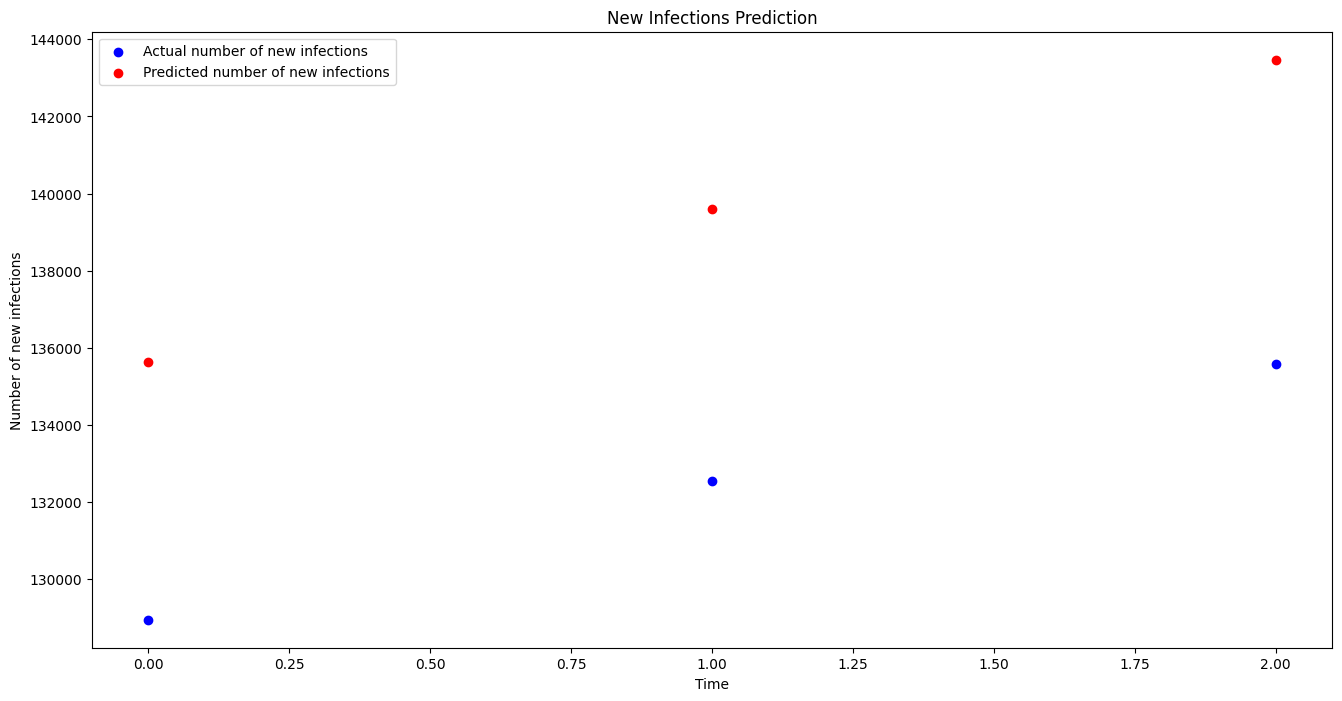

In [20]:
# Getting the real values
real_values = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting the results
plt.figure(figsize=(16,8))
plt.scatter(range(len(real_values)), real_values, color='blue', label='Actual number of new infections')
plt.scatter(range(len(predicted_values)), predicted_values, color='red', label='Predicted number of new infections')
plt.title('New Infections Prediction')
plt.xlabel('Time')
plt.ylabel('Number of new infections')
plt.legend()
plt.show()

### Your Task

- For this practical you will use the Indian Liver Patient Dataset (lipid ) data set. 

This data set contains 416 liver patient records and 167 non liver patient records.The data set was collected from north east of Andhra Pradesh, India. The class label divides the patients into 2 groups (liver patient or not). This data set contains 441 male patient records and 142 female patient records.


1. Load the whole Covid 19 infection count data set.
2. Subset the data where Country_Region = "China". Only take the data "Date" and  "ConfirmedCases" 
3. Split the data into train and test by leaving 10% data for test. 
4. Train a RNN classifier using the train data.
5. Apply the trained model on the test data.
6. Plot the predicted vs real infection values for the test data set. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

## Task 1. Load the whole Covid 19 infection count data set.
## Task 2. Subset the for China  

df = pd.read_csv('covid_19_complete_dataset.csv')

#  -------- Complte ----------- # 
# df_china = ...
# df_china.columns = ["date", "new_infections"]
# df_china

In [4]:
## Task 3. Split the data into train and test by leaving 10% data for test. 



In [3]:
## Task 4. Train a RNN classifier using the train data.




In [5]:
## Task 5. Apply the trained model on the test data.
## Task 6. Plot the predicted vs real infection values for the test data set. 

